### Retrieving annual unemployment rates for all available individual countries from IMF API for 2008-2016 for available years

Some directions and tips on syntax could be found [here](http://datahelp.imf.org/knowledgebase/articles/667681-json-restful-web-service)

1. Using requests module display all available databases at the IMF website

2. Investigate specifically IFS description and dimentions, display all available indicators and codes

3. Choose list of countries - filter out groups/irrelevant entitites from countries list

4. Create pandas dataframe and parse data where column heads are: country code, indicator code (Unemployment rate (percent) = LUR_PT, year(s) 

5. Save Dataframe to csv

6. Create a line plot of unemployment rate over time for Germany (change to anything) from 2008 until 2016 (or for whatevers years are available)

In [2]:
import requests
import pandas as pd
import csv, re, sys, os

In [3]:
# Find the series id (databases) and text name.
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/Dataflow/'
seriesids = requests.get(url).json()
df = pd.DataFrame(seriesids['Structure']['Dataflows']['Dataflow'])
print(len(df))
for x in range(0, 83):
     items = (str(df['@id'][x]), str(df['Name'][x]['#text']))
     print(': '.join(items))

83
DS-FAS: Financial Access Survey (FAS)
DS-IFS: International Financial Statistics (IFS)
DS-MCDREO: Middle East and Central Asia Regional Economic Outlook (MCDREO)
DS-DOT: Direction of Trade Statistics (DOTS)
DS-CDIS: Coordinated Direct Investment Survey (CDIS)
DS-GFS01M: Government Finance Statistics (GFS 2001) - Multidimensional
DS-GFS01: Government Finance Statistics (GFS 2001)
DS-BOP: Balance of Payments (BOP)
DS-BOPAGG: Balance of Payments (BOP), World and Regional Aggregates
DS-CPIS: Coordinated Portfolio Investment Survey (CPIS)
DS-APDREO: Asia and Pacific Regional Economic Outlook (APDREO)
DS-FM: Fiscal Monitor (FM)
DS-AFRREO: Sub-Saharan Africa Regional Economic Outlook (AFRREO)
DS-MCDREO201410: MCD Regional Economic Outlook October 2014
DS-FM201410: Fiscal Monitor (FM) October 2014
DS-AFRREO201410: Sub-Saharan Africa Regional Economic Outlook (AFRREO) October 2014
DS-MCDREO201501: MCD Regional Economic Outlook January 2015
DS-APDREO201410: Asia and Pacific Regional Economic 

In [4]:
# Annotations for the series
url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/DataStructure/IFS"
dotstruct = requests.get(url).json()
df = pd.DataFrame(dotstruct['Structure']['KeyFamilies']\
     ['KeyFamily']['Annotations'])
print(len(df))
for x in range(0, 8): 
     items = (str(df['Annotation'][x]['AnnotationTitle']), \
     str(df['Annotation'][x]['AnnotationText']['#text']))
     print(': '.join(items))

8
Latest Update Date: 03/27/2017
Name: International Financial Statistics (IFS)
Temporal Coverage: Data available starting in the 1948 for many IMF member countries. Varies by country.
Geographic Coverage: IFS covers 194 countries and areas.

Under the Fund’s legal framework, the member in effective control of a territory must report data respecting that territory. With respect to data on any territory whose status is the subject of a dispute between members, the IMF’s use of data on that territory provided by a member, either for surveillance or any other Fund activities, does not constitute a judgment by the IMF on the status of that territory.
Methodology: The International Financial Statistics is based on various IMF data collections. It includes exchange rates series for all Fund member countries plus Anguilla, Aruba, China, P.R.: Hong Kong, China, P.R.: Macao, Montserrat, and the Netherlands Antilles. It also includes major Fund accounts series, real effective exchange rates, and

In [5]:
# Look at structure of IFS data to find the dimensions for our data request
url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/DataStructure/IFS"
dotstruct = requests.get(url).json()
df = pd.DataFrame(dotstruct['Structure']['KeyFamilies']['KeyFamily']\
          ['Components']['Dimension'])
print(len(df))
for x in range(0, 3): 
     items = ("Dimension", str(x+1), str(df['@codelist'][x]))
     print(': '.join(items))

3
Dimension: 1: CL_FREQ
Dimension: 2: CL_AREA_IFS
Dimension: 3: CL_INDICATOR_IFS


In [6]:
# Obtain country codes
url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CodeList/CL_AREA_IFS"
country = requests.get(url).json()
df = pd.DataFrame(country['Structure']['CodeLists']['CodeList']['Code'])
print(len(df))
for x in range(0, len(df)): 
     items = (str(df['@value'][x]), str(df['Description'][x]['#text']))
        
     print(': '.join(items))

282
AF: Afghanistan
AL: Albania
DZ: Algeria
AS: American Samoa
AO: Angola
AI: Anguilla
AG: Antigua and Barbuda
5M: AMF (Arab Monetary Fund)
AR: Argentina
AM: Armenia
AW: Aruba
AU: Australia
AT: Austria
AZ: Azerbaijan
BS: Bahamas
BH: Bahrain
BD: Bangladesh
5W: BEAC (Banque des Etats de l`Afrique Centrale)
5B: BIS (Bank for International Settlements)
BB: Barbados
BY: Belarus
BE: Belgium
R1: Belgo-Luxembourg Economic Union
BZ: Belize
BJ: Benin
BM: Bermuda
BT: Bhutan
BO: Bolivia
BA: Bosnia and Herzegovina
BW: Botswana
BR: Brazil
BN: Brunei Darussalam
BG: Bulgaria
BF: Burkina Faso
BI: Burundi
CV: Cape Verde
KH: Cambodia
CM: Cameroon
CA: Canada
KY: Cayman Islands
CF: Central African Republic
1C_752: Central Bank West Africa
TD: Chad
CL: Chile
HK: Hong Kong, China
MO: Macao
CN: China
CO: Colombia
KM: Comoros
CD: Congo, the Democratic Republic of the
CG: Congo
CK: Cook Islands
CR: Costa Rica
CI: Cote d`Ivoire
HR: Croatia
CU: Cuba
CW: Curacao
1C_355: Curacao & St. Maarten
CY: Cyprus
CZ: Czech R

In [7]:
#Filter out not relevant grouping codes, no-country entities

def check_codes(item_code):
    no_list = ['1C_473','1C_459','CS','1C_568','PM','SH','1C_356','5H','7B','x0','1E','1C_977','4F','U2','5I','CSH','1C_355','1C_752','R1','5B','5W','5M','YUC']
    if item_code in no_list:
        return False
    else:
        return True
    
all_items = []
all_codes = []
for x in range(0, 239):
    item_code = str(df['@value'][x])
    item_name = str(df['Description'][x]['#text'])
    if check_codes(item_code):
        all_items.append('{}: {}'.format(item_code, item_name))
        all_codes.append(item_code)
    else:
        pass
#Return a clean list of countries and codes
#Only the list of codes will be used for further requests
print(all_items)

['AF: Afghanistan', 'AL: Albania', 'DZ: Algeria', 'AS: American Samoa', 'AO: Angola', 'AI: Anguilla', 'AG: Antigua and Barbuda', 'AR: Argentina', 'AM: Armenia', 'AW: Aruba', 'AU: Australia', 'AT: Austria', 'AZ: Azerbaijan', 'BS: Bahamas', 'BH: Bahrain', 'BD: Bangladesh', 'BB: Barbados', 'BY: Belarus', 'BE: Belgium', 'BZ: Belize', 'BJ: Benin', 'BM: Bermuda', 'BT: Bhutan', 'BO: Bolivia', 'BA: Bosnia and Herzegovina', 'BW: Botswana', 'BR: Brazil', 'BN: Brunei Darussalam', 'BG: Bulgaria', 'BF: Burkina Faso', 'BI: Burundi', 'CV: Cape Verde', 'KH: Cambodia', 'CM: Cameroon', 'CA: Canada', 'KY: Cayman Islands', 'CF: Central African Republic', 'TD: Chad', 'CL: Chile', 'HK: Hong Kong, China', 'MO: Macao', 'CN: China', 'CO: Colombia', 'KM: Comoros', 'CD: Congo, the Democratic Republic of the', 'CG: Congo', 'CK: Cook Islands', 'CR: Costa Rica', 'CI: Cote d`Ivoire', 'HR: Croatia', 'CU: Cuba', 'CW: Curacao', 'CY: Cyprus', 'CZ: Czech Republic', 'DK: Denmark', 'DJ: Djibouti', 'DM: Dominica', 'DO: Domi

In [7]:
#Display codes and indicators avaiaible in IFS
url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CodeList/CL_INDICATOR_IFS"
series = requests.get(url).json()
df = pd.DataFrame(series['Structure']['CodeLists']['CodeList']['Code'])
print(len(df))
for x in range(0, 2672): 
     items = (str(df['@value'][x]), str(df['Description'][x]['#text']))
     print(': '.join(items))

2672
AAP_IX: Agricultural Production, Index
PZPI_IX: All Commodities (Fuel and Non Fuel), Price, Index
PCPI_A1_IX: All items, Capital City, Index
IADD_BP6_USD: Assets, Direct investment, Debt instruments, US Dollars
IADE_BP6_USD: Assets, Direct investment, Equity and investment fund shares , US Dollars
IAD_BP6_USD: Assets, Direct investment, US Dollars
IAD_USD: Assets, FDI Abroad (BPM5), US Dollars
IADF_BP6_USD: Assets, Financial derivatives (other than reserves) and employee stock options , US Dollars
IAO_USD: Assets, Other Investment (BPM5), US Dollars
IAOB_USD: Assets, Other Investment, Banks (BPM5), US Dollars
IAOG_USD: Assets, Other Investment, General Government (BPM5), US Dollars
IAOA_USD: Assets, Other Investment, Monetary Authorities (BPM5), US Dollars
IAOE_BP6_USD: Assets, Other investment, Other equity , US Dollars
IAOOS_USD: Assets, Other Investment, Other Sectors (BPM5), US Dollars
IAP_BP6_USD: Assets, Portfolio investment , US Dollars
IAPXFD_USD: Assets, Portfolio Investm

In [8]:
#Test and investigate schema for one country (DE - Germany, A - annual, LUR_PT - unemployment rate in percent)
our = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/A.DE.LUR_PT?startPeriod=2008&endPeriod=2016'
odata = requests.get(our)
my_data = odata.json()
unempl = pd.DataFrame(my_data['CompactData']['DataSet']['Series'])
print(unempl)
unempl = pd.DataFrame(my_data['CompactData']['DataSet']['Series']['Obs'])
unempl.tail()


  @FREQ @INDICATOR @REF_AREA @TIME_FORMAT @UNIT_MULT  \
0     A     LUR_PT        DE          P1Y          0   
1     A     LUR_PT        DE          P1Y          0   
2     A     LUR_PT        DE          P1Y          0   
3     A     LUR_PT        DE          P1Y          0   
4     A     LUR_PT        DE          P1Y          0   
5     A     LUR_PT        DE          P1Y          0   
6     A     LUR_PT        DE          P1Y          0   
7     A     LUR_PT        DE          P1Y          0   
8     A     LUR_PT        DE          P1Y          0   

                                                 Obs  
0  {'@TIME_PERIOD': '2008', '@OBS_VALUE': '7.5416...  
1    {'@TIME_PERIOD': '2009', '@OBS_VALUE': '8.125'}  
2      {'@TIME_PERIOD': '2010', '@OBS_VALUE': '7.7'}  
3  {'@TIME_PERIOD': '2011', '@OBS_VALUE': '7.0583...  
4  {'@TIME_PERIOD': '2012', '@OBS_VALUE': '6.8333...  
5    {'@TIME_PERIOD': '2013', '@OBS_VALUE': '6.875'}  
6      {'@TIME_PERIOD': '2014', '@OBS_VALUE': '6.7'}  

@OBS_VALUE @TIME_PERIOD
4  6.83333333333333         2012
5             6.875         2013
6               6.7         2014
7               4.6         2015
8               4.1         2016

In [18]:
# Rename columns
unempl.columns = ['unempl','date']
print(unempl.tail())

# Set the observation value series (percentage) as a float (rather than string)
unempl.unempl = unempl.unempl.astype(float)

# Read the dates as years and set as the dataframe index
rng = pd.date_range(pd.to_datetime(unempl.date[0]), periods=len(unempl.index), freq='A')
unempl = unempl.set_index(pd.DatetimeIndex(rng))

# Show last five rows
print(unempl.tail())

              unempl  date
2012-12-31  6.833333  2012
2013-12-31  6.875000  2013
2014-12-31  6.700000  2014
2015-12-31  4.600000  2015
2016-12-31  4.100000  2016
              unempl  date
2012-12-31  6.833333  2012
2013-12-31  6.875000  2013
2014-12-31  6.700000  2014
2015-12-31  4.600000  2015
2016-12-31  4.100000  2016


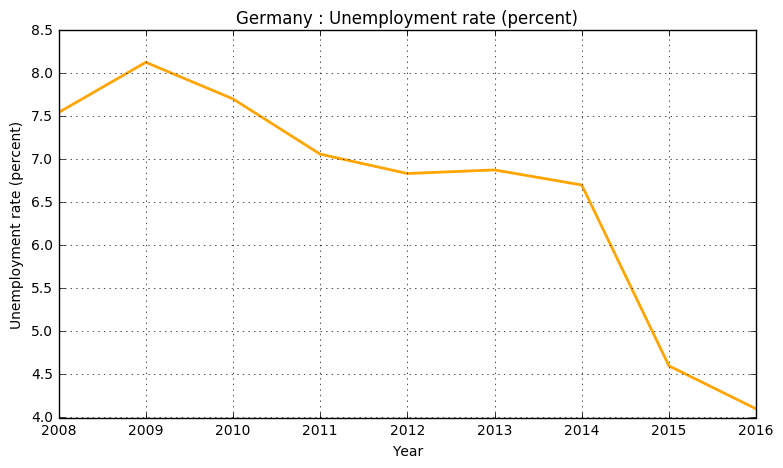

In [11]:
# import matplotlib and pyplot
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Create line plot and add labels and title
unempl.unempl.plot(grid=True, figsize=(9, 5), color="orange", linewidth=2,)
plt.ylabel('Unemployment rate (percent)')
plt.xlabel('Year')
plt.title('Germany : Unemployment rate (percent)');

The script below tries to grab data for all countries for years available between 2008 until 2016 and create a pandas DataFrame.

Due to a limit on a number of series you can ask an API per single request, I split my requests by three manually.

This is a very dirty way to split requests, later on I will update the script and put a more appropriate function.

In [16]:
#get a string of country codes joint by a plus sign (Only useful for further parsin of a query)
all_cou = '+'.join(all_codes)
#print(all_cou)

def get_data():
    #Three splits of queries
    our ='http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/A.AF+AL+DZ+AS+AO+AI+AG+AR+AM+AW+AU+AT+AZ+BS+BH+BD+BB+BY+BE+BZ+BJ+BM+BT+BO+BA+BW+BR+BN+BG+BF+BI+CV+KH+CM+CA+KY+CF+TD+CL+HK+MO+CN+CO+KM+CD+CG+CK+CR+CI+HR+CU+CW+CY+CZ+DK+DJ+DM+DO+EC+EG+SV+GQ+ER+EE+ET+FK+FO+FJ+FI+FR+PF+NC+GA+GM+GE+DE.LUR_PT?startPeriod=2008&endPeriod=2016'
    our2 ='http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/A.GH+GI+GR+GL+GD+GP+GU+GT+GF+GN+GW+GY+HT+HN+HU+IS+IN+ID+X0+IR+IQ+IE+IL+IT+JM+JP+JO+KZ+KE+KI+KR+XK+KW+KG+LA+LV+LB+LS+LR+LY+LT+LU+MK+MG+MW+MY+MV+ML+MT+MH+MQ+MR+MU+MX+FM+MD+MN+ME+MS+MA+MZ+MM.LUR_PT?startPeriod=2008&endPeriod=2016'
    our3 = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/A.NA+NR+NP+NL+AN+NZ+NI+NE+NG+NO+OM+PK+PW+PA+PG+PY+PE+PH+PL+PT+QA+RE+RO+RU+RW+WS+SM+ST+SA+SN+RS+SC+SL+SG+SX+SK+SI+SB+SO+ZA+SS+ES+LK+KN+LC+VC+SD+SR+SZ+SE+CH+SY+TW+TJ+TZ+TH+TP+TL+TG+TO+TT+TN+TR+TM+TV+UG+UA+AE+GB+US+UY+UZ+VU+VE+VN+PS+YE+ZM+ZW.LUR_PT?startPeriod=2008&endPeriod=2016'

    #Requesting data for three queries defined above
    odata = requests.get(our)
    my_data = odata.json()
    listing1 = my_data['CompactData']['DataSet']['Series']
    odata = requests.get(our2)
    my_data = odata.json()
    listing2 = my_data['CompactData']['DataSet']['Series']
    odata = requests.get(our3)
    my_data = odata.json()
    listing3 = my_data['CompactData']['DataSet']['Series']
    
    #Join results of queries
    listing = listing1 + listing2 + listing3
    print(len(listing))
    countries= []
    indicators=[]
    vals = []
    years = []
    for i in range(0, len(listing)):
        country = listing[i]['@REF_AREA']
        indicator =listing[i]['@INDICATOR']
        item = listing[i]
        #Checks if any data exists at all for a country, if not: 'missing' will be in year and value columns
        if 'Obs' in item:
            obs = item['Obs']
            #Check if more than 1 obs exists -> results are in a list instead of dictionary (1 d. p.))
            if isinstance(obs, dict):
                print(obs)
                val = obs['@OBS_VALUE']
                year = obs['@TIME_PERIOD']
                countries.append(country)
                indicators.append(indicator)
                years.append(year)
                vals.append(val)
            else:
                for x in range(0,len(obs)):
                    #Iterate through the list of observations and append to a list
                    #if nothing returned = KeyError - put 'none'
                    if '@OBS_VALUE' in obs[x]:
                        val = obs[x]['@OBS_VALUE']
                    else:
                        val = 'NaN'
                    if '@TIME_PERIOD' in obs[x]:
                        year = obs[x]['@TIME_PERIOD']
                    else:
                        year = 'NaN'
                    countries.append(country)
                    indicators.append(indicator)
                    years.append(year)
                    vals.append(val)
        else:
            countries.append(country)
            indicators.append(indicator)
            years.append('NaN')
            vals.append('NaN')
    df = pd.DataFrame({'country': countries, 'indicator': indicators, 'date': years, 'value': vals})
    df.value = df.value.astype(float)
    rng = pd.date_range(pd.to_datetime(df.date[0]), periods=len(df.index), freq='A')
    df = df.set_index(pd.DatetimeIndex(rng))
    return df

#Call function above
df = get_data()

print(df.tail())

#Optional to delete lists of values
#del countries, indicators, years, vals

102
{'@TIME_PERIOD': '2015', '@OBS_VALUE': '27.2361'}
{'@TIME_PERIOD': '2009', '@OBS_VALUE': '2'}


OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 2262-12-31 00:00:00

In [19]:
#Save to csv file
df.to_csv('/Users/dariaulybina/Desktop/georgetown/global-economics/additional_data/data_csv/LUR_PT.csv')